# Project Report


## Title: Grand Slam Off the Court

Group Number: 20

Group Members: Manushree Singhania, Bryan Chang, Yoson Hsu, Shubham Sharma

Data Set: Player Stats for Top 500 Players


In [28]:
library(tidyverse)
library(repr)
library(digest)
library(GGally)
library(ISLR)
library(lubridate)
library(tidymodels)
library(dplyr)

set.seed(1234)

## Introduction

With the commercialization of modern sports, it would be of interest to know how much our beloved athletes are profiting from their careers. In this analysis, we look at the earnings of male tennis stars. We know that players with the highest ATP (governing body for male tennis) singles rankings are winners on the court, yet we cannot confirm that such wins translate off the court financially. As such, we built a K-NN regression model for this project which can answer the following question: Given a player’s metrics, can we predict a player’s career earnings in USD from tennis alone at a given point in their career?

The data set we are using, “Player Stats for Top 500 Players”, has been published by the ATP with data on the world’s top 500 ranked active male tennis players as of the end of the 2021 ATP Tour (sometime in late 2021). The data set is largely empty for lower-ranked players, and more detailed for players who have enjoyed higher levels of success. There are 38 columns of data, including players’ instagram usernames, nicknames, and the year they became professional tennis players. Such columns are largely irrelevant to our analysis, and this will become more obvious as we talk about how we cleaned this data.



## Methods and Results

Before even touching R, we had to start by getting the data onto our local repositories. Our data set was already on both Google Drive and GitHub; we forked it. Having created a remote repository, and adding all our group members as collaborators, we were ready to finally move work to and from GitHub to our local repositories; this would be JupyterHub in our case.

All libraries used came from worksheets and the textbook. We started by using the read_csv function to read our data into JupyterHub from Google Drive. We renamed many of the columns from the original dataset according to the course’s naming convention which made the process of referring to the columns more convenient. As stated earlier, there were some columns that were simply irrelevant to our analysis as they would not have any effect on a player’s career earnings from tennis alone. Furthermore, there were many columns in the original data frame that had special characters such as the dollar sign, “cm.” following each player’s height, and other miscellaneous descriptions regarding players’ data. We separated this information from the columns and converted them into their appropriate data types through the usage of the mutate, separate, as.numeric and gsub function. This way, we could set regular expressions to overwrite strings that included special characters, such as the dollar sign. Moreover, all values containing NA were filtered out since blank data could skew our model.


Following data wrangling/cleaning, we were left with a data set with eight columns, and 101 players. The columns are as follows: age, handedness, highest ATP singles ranking ever achieved, player name, backhand play style, height (in centimetres), seasons active as a professional, and cumulative career earnings from tennis only in USD (no endorsements/sponsorship earnings). We have players who have ranked as high as one on the ATP singles rankings all the way to players who ranked in the 200-300 range. There are players who have only been active for a few seasons, and others who have been active for over twenty years as a professional player. Five of the columns are quantitative, and three of the columns are categorical.


In [29]:
#read the data through the given url
player_stats_raw <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")


#select the required columns of the data, convert the the characters into doubles and integers for best rank, prize money, age
# renamed the columns to give them meaningful names, filtered the rows where values were unavailable i.e. NA. Covereted the 
# coolumns for Backhand, Handedness as factors. Added a new column to demonstrate whether the carrer earnings of a player 
# is within the top 30 career earnings of the player all over the world.

player_stats_refined <- player_stats_raw %>%
                        select(Age, Plays, 'Best Rank', Name, Backhand, 'Prize Money', Height, Seasons) %>%
                        separate(col = 'Best Rank', into = c('Best Rank', 'Date of Best Rank'), sep = " ", convert = TRUE) %>%
                        rename(Best_Rank = 'Best Rank', Date_of_Best_Rank = 'Date of Best Rank', Prize_Money = 'Prize Money') %>%
                        select(-Date_of_Best_Rank) %>%
                        filter(Height != "NA") %>%
                        separate(col = Age, into = c('Age', 'DOB'), sep = " ", convert = TRUE) %>%
                        separate(col = Prize_Money, into = c('Prize_Money', 'PMO'), sep = " ", convert = TRUE) %>%
                        select(-DOB) %>%
                        rename(Handedness = 'Plays')


player_stats_refined$Prize<-gsub("[^0-9]","",player_stats_refined$Prize_Money)
player_stats_refined <- player_stats_refined %>%
                        select(-PMO,-Prize_Money)%>%
                        mutate(Prize=as.numeric(Prize))%>%
                        filter(Prize != "NA")%>%
                        arrange(by= desc(Prize))



thirty_prize_money <- player_stats_refined$Prize[30] 


player_stats_mutated <- player_stats_refined %>%
                        mutate(Backhand=as_factor(Backhand))%>%
                        mutate(Handedness=as_factor(Handedness))

player_stats_mutated$Height<-gsub("[^0-9]","",player_stats_mutated$Height)

player_stats_mutated <- player_stats_mutated %>%
                        mutate(Height=as.numeric(Height))%>%
                        rename(Seasons_active=Seasons, Career_earnings=Prize)

player_stats_mutated

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.

Warning message:
“Expected 2 pieces. Additional pieces discarded in 20 rows [3, 26, 32, 36, 48, 49, 61, 62, 73, 79, 80, 85, 91, 100, 104, 106, 107, 112, 113, 115].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 91 rows [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, ...].”


Age,Handedness,Best_Rank,Name,Backhand,Height,Seasons_active,Career_earnings
<int>,<fct>,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
33,Left-handed,1,Rafael Nadal,Two-handed,185,19,119601561
31,Right-handed,3,Juan Martin Del Potro,Two-handed,198,14,25889586
26,Right-handed,4,Dominic Thiem,One-handed,185,10,22132368
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,Right-handed,183,Laurynas Grigelis,Two-handed,183,8,327684
28,Right-handed,286,Sandro Ehrat,Two-handed,180,3,95194
32,Right-handed,28,Santiago Giraldo,Two-handed,188,14,4416


After much pondering, we decided upon using age, highest ATP ranking ever achieved, height, and seasons active as our predictors for career earnings from tennis. Our main reason for choosing these predictors is that they are all quantitative (which is needed for regression) and, in theory, they should all have some effect on career earnings. Age and seasons active are similar in the sense that older/more experienced players have likely accumulated more career earnings, simply because they have been playing for a longer time. A player’s highest ever ATP ranking should also have a strong, albeit negative, association with career earnings; better performance technically means ranking decreases in magnitude. For instance, the top ranked player is rank one, not rank one million or something absurdly high, hence why this correlation would be negative. As for height, there is generally a sweet range of height where players succeed the most. Shorter players tend to lack power, whereas taller players tend to lack agility; a medium height could predict for favourable athleticism, and thus higher earnings from tennis.


In [30]:
num_obs <- nrow(player_stats_mutated)



#Count the number of players for each type of handedness i.e. Left-handed and Right-Handed
player_Handedness <- player_stats_mutated %>%
                        group_by(Handedness)%>%
                        summarize(
                                count = n(),
                        percentage = n() / num_obs * 100)

#Count the number of players for each type of Backhand i.e. Two-handed and One-handed
player_Backhand <- player_stats_mutated %>%
                        group_by(Backhand)%>%
                        summarize(
                                count = n(),
                        percentage = n() / num_obs * 100)
player_Handedness
player_Backhand

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



Handedness,count,percentage
<fct>,<int>,<dbl>
Left-handed,14,13.86139
Right-handed,87,86.13861


Backhand,count,percentage
<fct>,<int>,<dbl>
Two-handed,82,81.18812
One-handed,19,18.81188


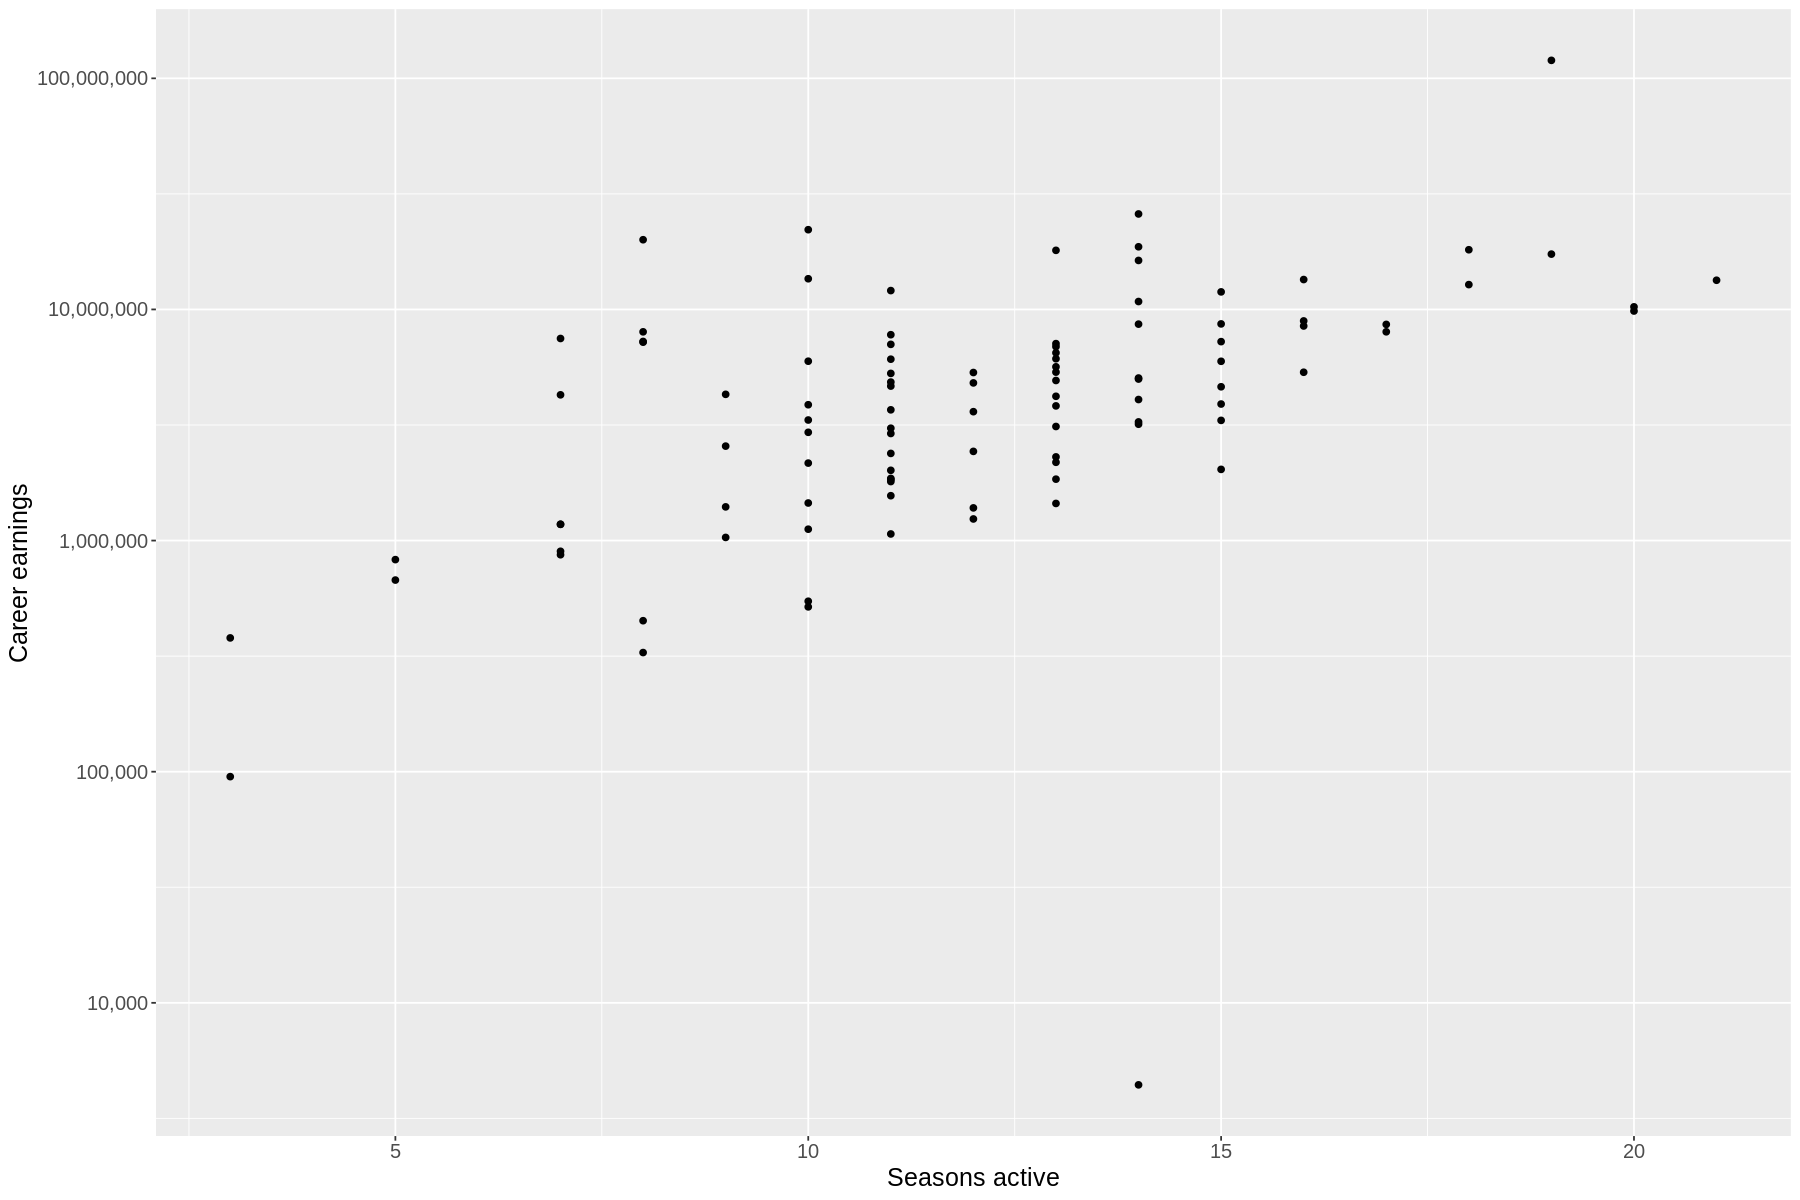

In [31]:
options(repr.plot.height = 10, repr.plot.width = 15)

seasons_v_pm <- ggplot(player_stats_mutated, aes(x = Seasons_active, y = Career_earnings))+
      geom_point() +
      labs(x = "Seasons active", y = "Career earnings") + 
        theme(text= element_text(size=15))+
        scale_y_log10(labels= label_comma())

seasons_v_pm

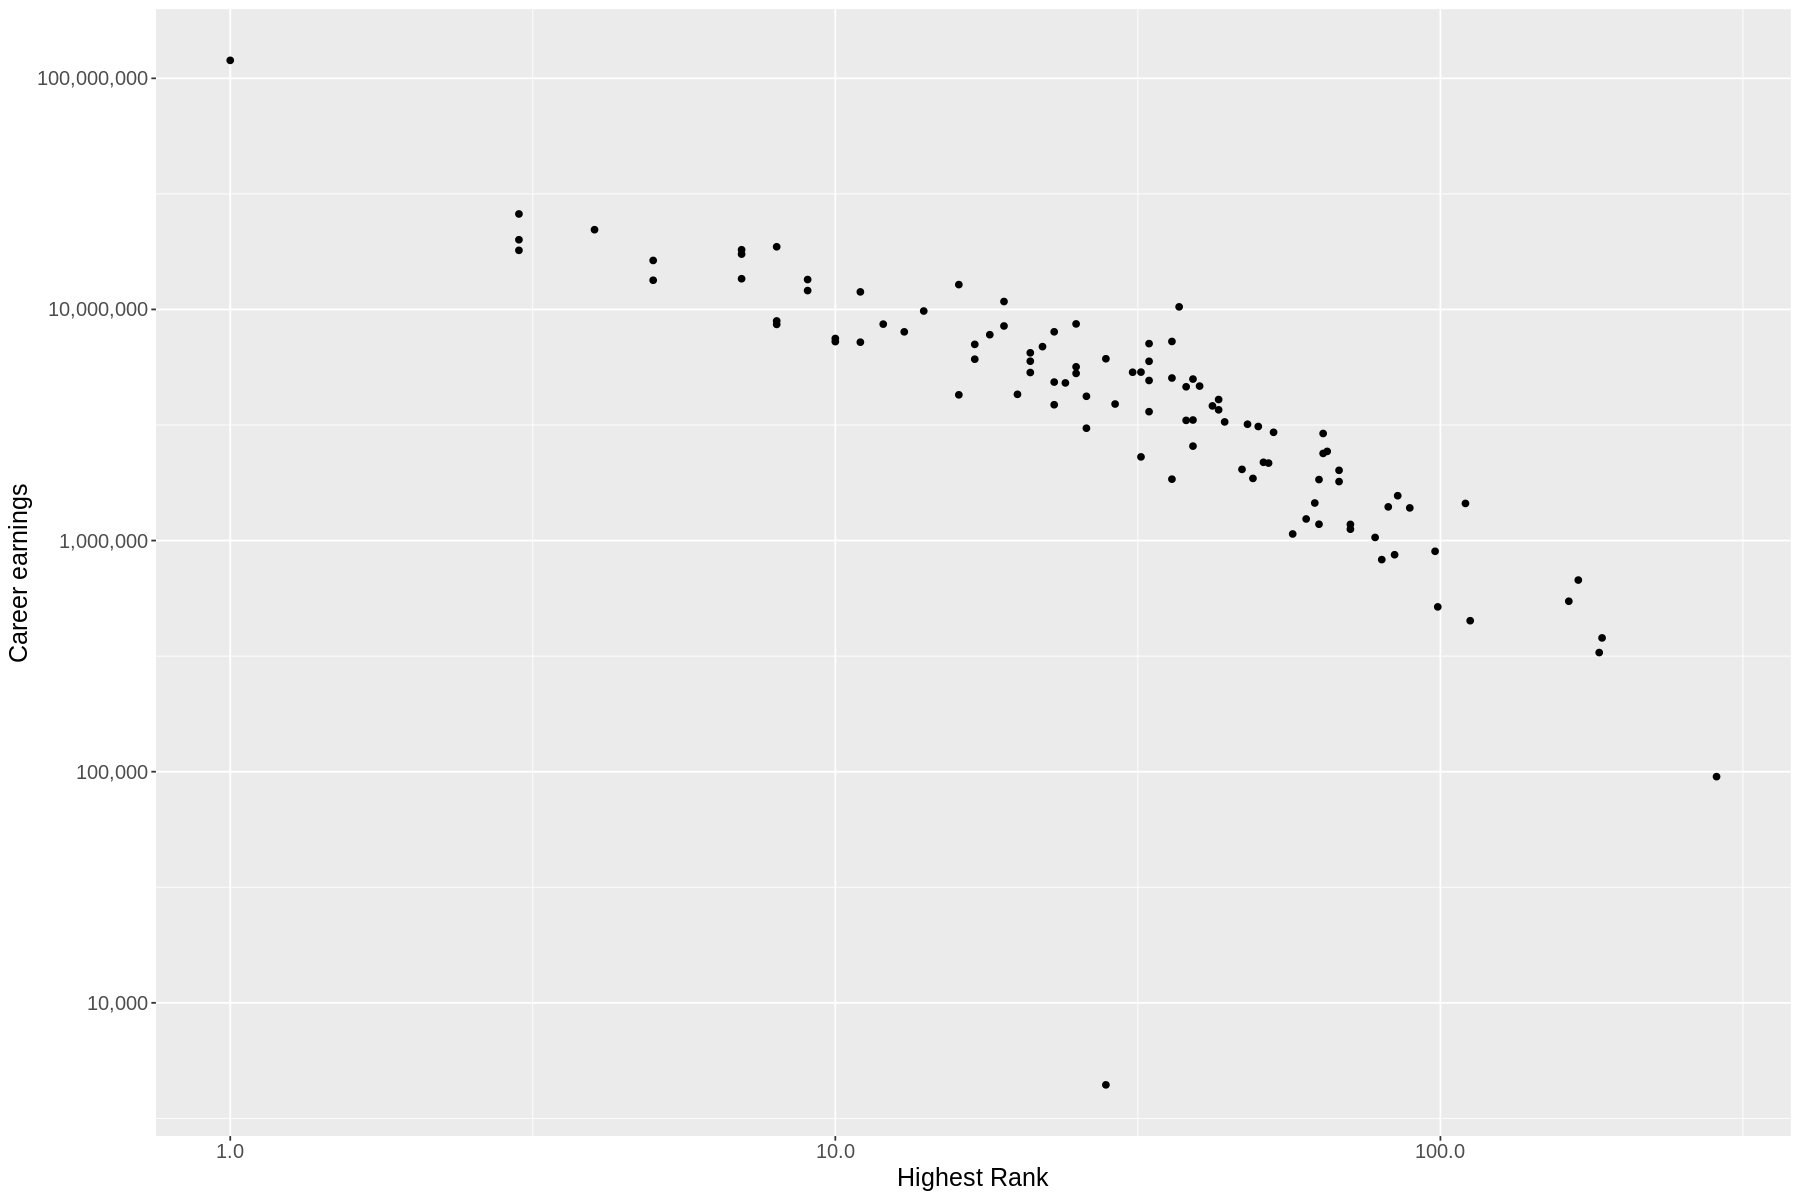

In [32]:
best_rank_vs_pm <- ggplot(player_stats_mutated, aes(x = Best_Rank, y = Career_earnings))+
      geom_point() +
      labs(x = "Highest Rank", y = "Career earnings") + 
        theme(text= element_text(size=15))+
        scale_y_log10(labels= label_comma())+
        scale_x_log10(labels= label_comma())

        
best_rank_vs_pm

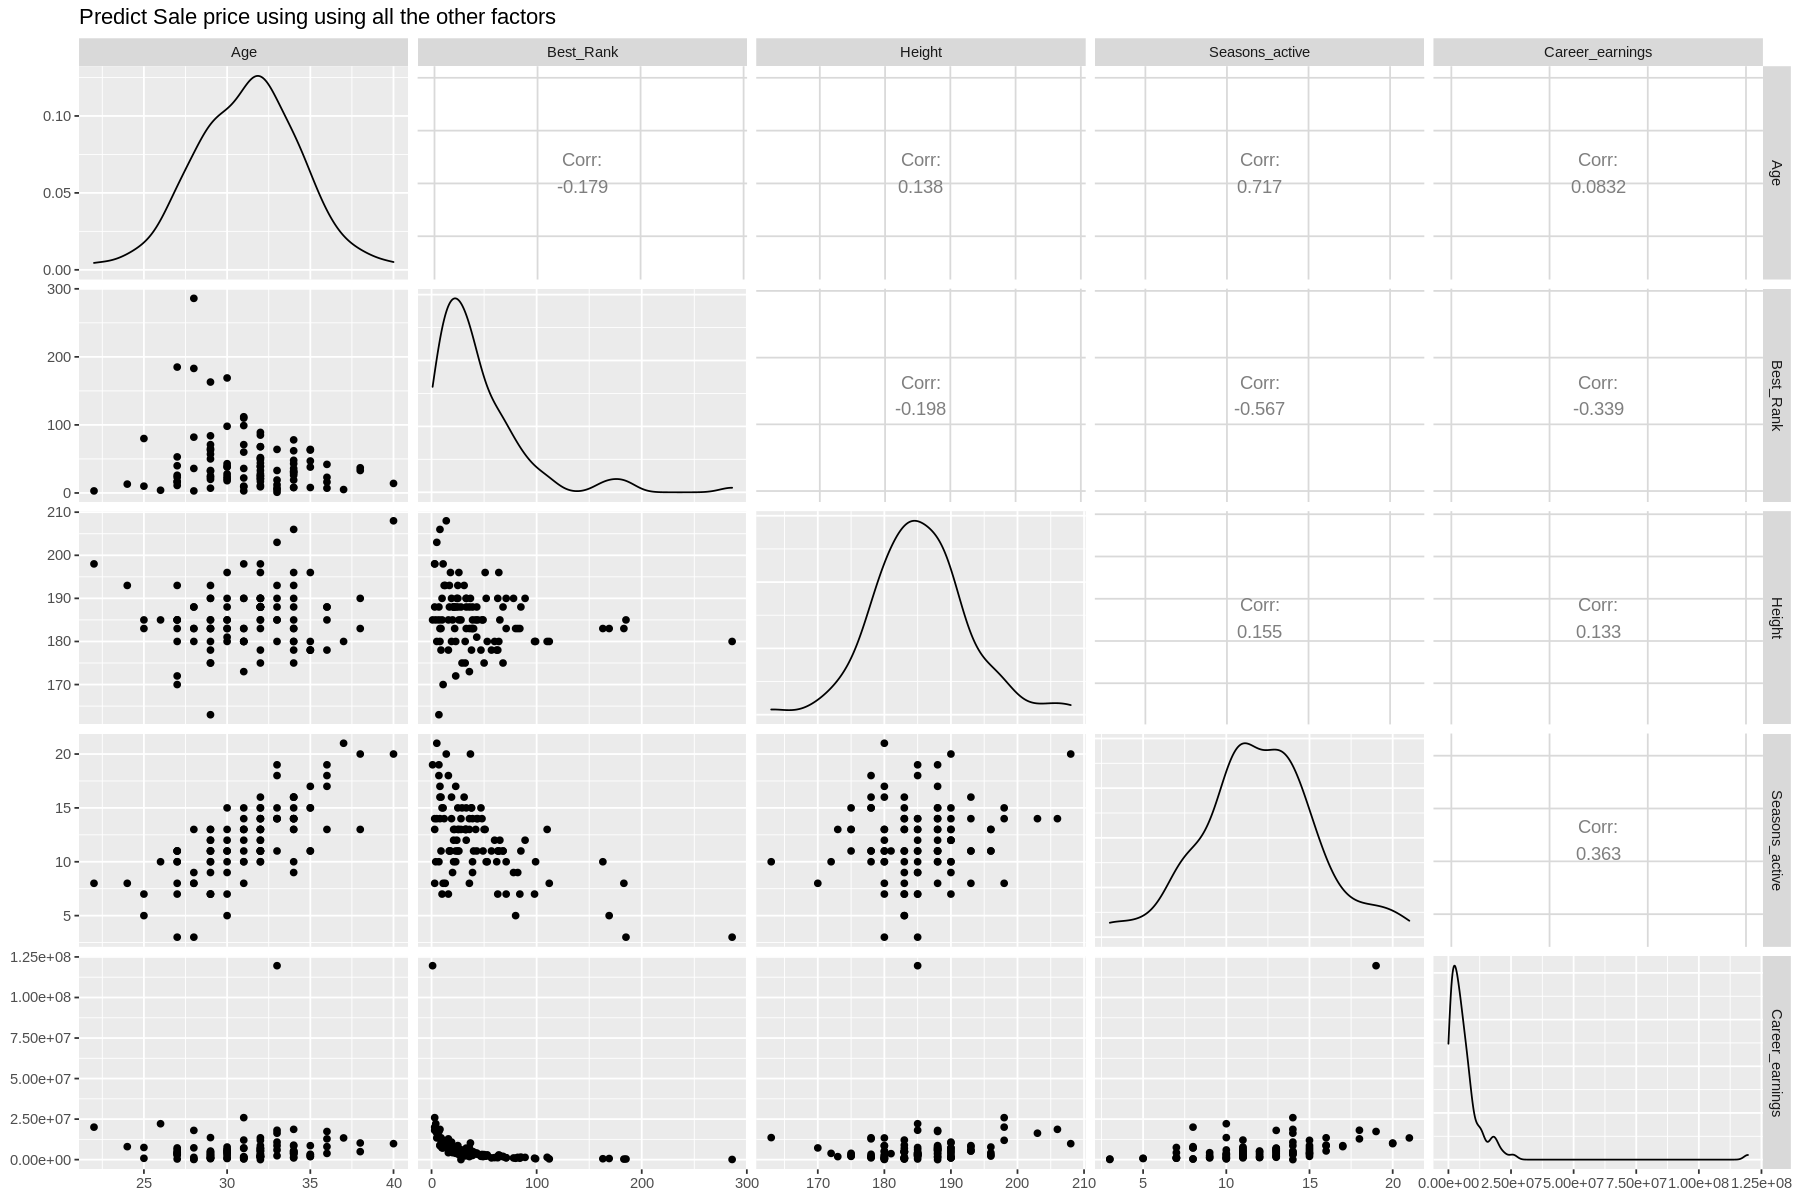

In [33]:
player_train_viz <- player_stats_mutated %>%
                    select(-Handedness,-Name,-Backhand)

player_train_viz_plot <- ggpairs(player_train_viz, columns= 1:5,title="Predict Sale price using using all the other factors")
player_train_viz_plot

Since we are predicting for career earnings in USD, a quantitative variable, this is a regression problem. We decided to conduct our analysis using KNN regression. This was due to the fact that some of the relationships between our predictors and the target variable aren’t linear. Our preliminary scaled graph between seasons active and career earnings is relatively linear. On the other hand, our preliminary scaled graph between a player’s highest ATP ranking and their career earnings has a slight curve. Even in theory, the relationship between our predictors and career earnings should not be linear. Players who have achieved a highest career ranking within the top ten, means that they likely accumulated higher career earnings due to prize money from their success in ATP tournaments (which is what determines ranking) over players who have not ever ranked this high.

One of the strengths of the KNN regression algorithm is the fact that it has few assumptions regarding the shape of the data (Timbers et al., 2022); it generally works well with non-linear relationships. For a more extensive look at the relationship between the predictors and target variable, we used the ggpairs function to take a look at these relationships using graphs and correlations. Through these graphs, all predictors appeared to have correlation to some degree with career earnings. Therefore, we decide to use all four variables as predictors for our model as they all appear to have some influence on a player’s career earnings.



We split up our cleaned data frame into training and testing data using a proportion of 0.75 and stratified for career earnings, the variable which we are building a regression model for. We had 101 players to work on; this is already a relatively small data frame. A 0.75 proportion resulted in 77 players going to the training set, whereas 24 players went to the testing data set. A 0.75 proportion split felt right because 77 players should cover a wide enough range of players: this should include some players who were extremely successful and those who never cracked the top 200 in the world for singles rankings.

This section was done to check that the training data, and subsequently the testing data, had a realistic proportion of players with certain handedness and backhand style. By comparing the proportions within the training data to the entire clean data set, we see that each proportion differs from the tidy data set by no more than 2%. This is good; we want our training and testing data to resemble that of the original tidy data set.



In [34]:
# Dividing the data into training and testing set with 75% data in training set and 25% in testing set.

options(repr.plot.height = 5, repr.plot.width = 6)

player_split <- initial_split(player_stats_mutated, prop = 0.75, strata = Career_earnings)  
player_train <- training(player_split)   
player_test <- testing(player_split)

player_train
player_test

Age,Handedness,Best_Rank,Name,Backhand,Height,Seasons_active,Career_earnings
<int>,<fct>,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
33,Left-handed,1,Rafael Nadal,Two-handed,185,19,119601561
31,Right-handed,3,Juan Martin Del Potro,Two-handed,198,14,25889586
26,Right-handed,4,Dominic Thiem,One-handed,185,10,22132368
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,Right-handed,183,Laurynas Grigelis,Two-handed,183,8,327684
28,Right-handed,286,Sandro Ehrat,Two-handed,180,3,95194
32,Right-handed,28,Santiago Giraldo,Two-handed,188,14,4416


Age,Handedness,Best_Rank,Name,Backhand,Height,Seasons_active,Career_earnings
<int>,<fct>,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
22,Right-handed,3,Alexander Zverev,Two-handed,198,8,20028563
36,Left-handed,7,Fernando Verdasco,Two-handed,188,19,17353811
32,Right-handed,25,Jeremy Chardy,Two-handed,188,15,8658443
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
34,Right-handed,78,Konstantin Kravchuk,Two-handed,190,9,1031708
30,Right-handed,98,Andrej Martin,Two-handed,180,7,898701
31,Right-handed,112,Attila Balazs,Two-handed,180,8,450046



We can start putting a workflow together to find the optimal value of K for our model. We started by creating a model specification using the nearest neighbor function; we used tune() as an argument for neighbors as taught in class, and set the mode to regression as we are performing regression. We then preprocessed our training data using a recipe, ensuring that the testing data had no effect on our model; this would be like cheating, otherwise! Using a recipe, we specified what variable we were predicting for, all predictors used in said prediction, and scaled all training data using the step_scale and step_center functions for the purpose of making sure all predictors have an equal amount of influence on predicted career earnings. The data was then put into a workflow.

In [35]:
# Creating a model specification for knn regression model to find the most accurate number od neighbors


player_spec <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune())%>%
                          set_engine("kknn") %>%
                          set_mode("regression")

# creating the recipe for the knn regression on training set of the dataframe player 
player_recipe <- recipe(Career_earnings ~ Height+ Age+ Best_Rank+ Seasons_active, data = player_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())


#crreating a workflow for knn regression to find the appropriate number of neighnors to perform regression
player_wkflw <- workflow() %>%
  add_recipe(player_recipe) %>%
  add_model(player_spec)

player_wkflw
player_train


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Age,Handedness,Best_Rank,Name,Backhand,Height,Seasons_active,Career_earnings
<int>,<fct>,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
33,Left-handed,1,Rafael Nadal,Two-handed,185,19,119601561
31,Right-handed,3,Juan Martin Del Potro,Two-handed,198,14,25889586
26,Right-handed,4,Dominic Thiem,One-handed,185,10,22132368
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,Right-handed,183,Laurynas Grigelis,Two-handed,183,8,327684
28,Right-handed,286,Sandro Ehrat,Two-handed,180,3,95194
32,Right-handed,28,Santiago Giraldo,Two-handed,188,14,4416


Next, we performed 5-fold cross-validation. We wanted to use a round number for the number of folds, and we felt as if ten would be too large for our training data set of 77 players. Having ten or more folds would be prone to skewness as each fold would be really small and could contain a sample not resemblant of the true population. Additionally, a 10-fold cross-validation process would also require a lot of computation, which is not feasible. Cross-validation came next for values of K ranging from 1 to 60, skipping by 2.

In [36]:
player_vfold <- vfold_cv(player_train, v = 5, strata = Career_earnings)

#running cross-validation for a grid of numbers of neighbors ranging from 1 to 200.
gridvals <- tibble(neighbors = seq(from = 1, to = 60, by = 2))

player_results <- player_wkflw %>%
  tune_grid(resamples = player_vfold, grid = gridvals) %>%
  collect_metrics() %>%
  filter(.metric == "rmse")

player_results



Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”
x Fold1: model 1/1: Error in best[1, 2]: subscript out of bounds



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,15378160,4,6498794,Model01
3,rmse,standard,12476535,4,5261219,Model02
5,rmse,standard,10608203,4,5986588,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,rmse,standard,10996822,4,6161707,Model28
57,rmse,standard,11141467,4,6122258,Model29
59,rmse,standard,11388593,4,6052002,Model30


Using the above data, we computed a graph between the values of K against the root mean squared prediction error (RMSPE) for each value of K. The formula for calculating RMSPE can be found in chapter 7.6 of Data Science A First Introduction (Timbers et al., 2022). RMSPE is a margin of prediction error. The optimal value of K is the value of K which produces the lowest RMSPE, and thus the value of K we’ll use for testing data. Through our graph for K plotted against RMPSE, we saw that the minimum value of RMPSE occurs at K=17.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,rmse,standard,10083672,4,6384767,Model09


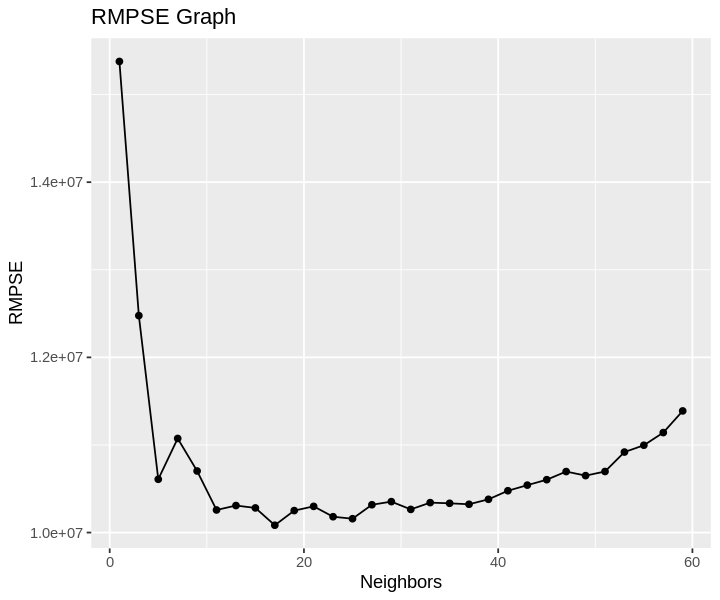

In [37]:
# visualizing how the RMSPE varies with the number of neighbors K
 
neighbor_pplot <-  ggplot(player_results, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "RMPSE")+
        ggtitle("RMPSE Graph")

neighbor_pplot

# taking the minimum RMSPE to find the best setting for the number of neighbors

minimum_error <- player_results %>%
                arrange(mean) %>% 
   slice(1)

minimum_error

k_min <- minimum_error %>%
         pull(neighbors)

Using K=17, we evaluated the model on test data. The process is largely the same as when creating the model itself, apart from the fact that we now summarize how well the model works on testing data using the predict and bind_cols functions. Yet again, we used a workflow; the difference was that we used a model specification which used 17 as our argument for neighbors. After summarizing our predictions, we created a tibble that gave us summary statistics regarding our model on testing data.

In [38]:
# re-training our KNN regression model on the entire training data set, using K = 17 neighbors

player_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
         set_engine("kknn") %>%
         set_mode("regression")

player_best_fit <- workflow() %>%
         add_recipe(player_recipe) %>%
         add_model(player_best_spec) %>%
         fit(data = player_train)

# making predictions on the test data, and use the metrics function to compute the summary of regression quality

player_summary <- player_best_fit %>%
          predict(player_test) %>%
          bind_cols(player_test) 
player_metrics <- player_summary%>%
          metrics(truth = Career_earnings, estimate = .pred)

player_summary 
player_metrics

.pred,Age,Handedness,Best_Rank,Name,Backhand,Height,Seasons_active,Career_earnings
<dbl>,<int>,<fct>,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
6261037,22,Right-handed,3,Alexander Zverev,Two-handed,198,8,20028563
14166908,36,Left-handed,7,Fernando Verdasco,Two-handed,188,19,17353811
6655484,32,Right-handed,25,Jeremy Chardy,Two-handed,188,15,8658443
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2651444,34,Right-handed,78,Konstantin Kravchuk,Two-handed,190,9,1031708
1555167,30,Right-handed,98,Andrej Martin,Two-handed,180,7,898701
1591829,31,Right-handed,112,Attila Balazs,Two-handed,180,8,450046


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.378084e+06
rsq,standard,4.791937e-01
mae,standard,2.012448e+06


The true values were then plotted against the predicted values, showing a graph with many steep, sharp kinks (edges which don’t look linear) thereby indicating that our model has not performed very well in predicting career earnings. 


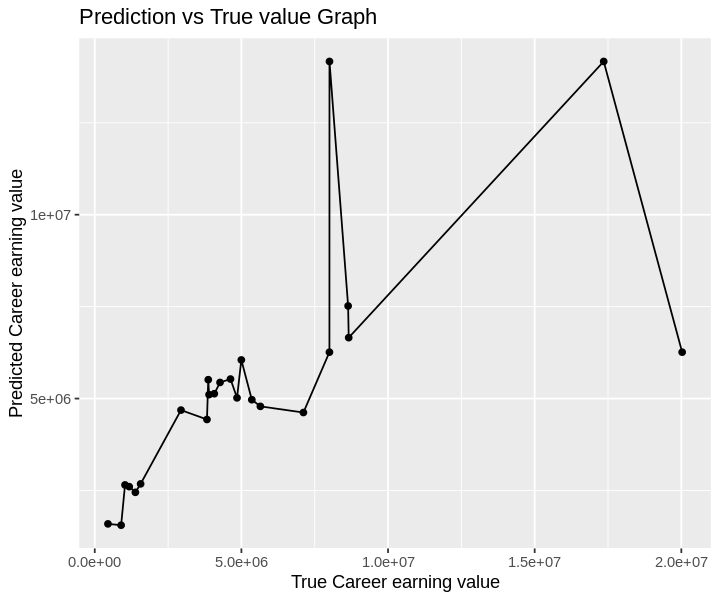

In [39]:
prediction_pplot <-  ggplot(player_summary , aes(x = Career_earnings, y = .pred))+
      geom_point() +
      geom_line() +
      labs(x = "True Career earning value", y = "Predicted Career earning value")+
        ggtitle("Prediction vs True value Graph")

prediction_pplot

Lastly, upon recommendation by a TA, we used forward selection to see if there were any predictors which were irrelevant to our analysis. We conducted the process of forward selection because the RMSPE for our model is extremely large. This part of our analysis was heavily reliant on chapter 6.8.3 of Data Science A First Introduction (Timbers et al., 2022). The essence of the forward selection code used in the textbook is that for loops are used so that a predictor is added each round. When this happens, a model formula is created, passed into a recipe, builds a workflow that tunes the value of K using 5-fold cross-validation, and outputs the metric of interest in a tibble. For us, this metric of interest is RMSPE. 


In [40]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     rmse = numeric())

player_spec <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune())%>%
                          set_engine("kknn") %>%
                          set_mode("regression")

names <- colnames(player_train_viz %>% select(-Career_earnings))

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Career_earnings", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        player_recipe <- recipe(as.formula(model_string), 
                                data = player_train_viz) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN regression model with these predictors, 
        # and collect the rmse for the best K
        acc <- workflow() %>%
          add_recipe(player_recipe) %>%
          add_model(player_spec) %>%
          tune_grid(resamples = player_vfold, grid = 5) %>%
          collect_metrics() %>%
          filter(.metric == "rmse") %>%
          summarize(mx = min(mean))
        
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              rmse = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,rmse
<int>,<chr>,<dbl>
1,Career_earnings ~ Age,11355856
2,Career_earnings ~ Age+Height,11177416
3,Career_earnings ~ Age+Height+Seasons_active,9766870
4,Career_earnings ~ Age+Height+Seasons_active+Best_Rank,9479199


# Discussions

In the end, we found that our final model’s RMSPE was USD 3378084, approximately a third of our cross-validation RMSPE estimate using K=17, which was USD 10083672. We did not anticipate that the final model’s RMSPE would be so far off from the cross-validation RMSPE; the RMSPE of the cross-validation model is nearly equivalent to the earnings of the richest player in the entire dataset. This led us to think, was it possible that one of the predictors wasn’t actually helping the model?


This leads us to discussion on why we used forward selection. The result of forward selection shows that when you add height as a predictor to age, the RMSPE barely decreases. This indicates that height is a highly irrelevant predictor compared to seasons active and highest rank because the RMSPE does not decrease as much when height. Since the seasons active and highest rank variables reduce the error by a large margin, we can infer that they are both crucial predictors in determining a player’s earning, along with a player’s age. As stated earlier, we found that adding in height as a predictor only minimally decreased the RMSPE as compared to the other three predictors. If we were to redo this analysis, we would certainly do it without height as a predictor. This result contradicts our assumption based on logical understanding of the sport and the observation of the preliminary visualizations that our four predictors were important in predicting a player’s career earnings.


The implications of such findings are admittedly narrow, but can definitely be expanded upon in future studies. As ATP tournaments run concurrently, players can choose which tournaments to attend. Generally, larger tournaments garner more ATP points, as well as prize money for players. Supposedly, predicting a player’s career earnings from playing tennis alone can be compared to their earnings from endorsements/sponsors. This would allow us to see if there is a correlation between attaining wealth vs popularity (since endorsements are largely based on marketability). Some other thoughts are that there can be future studies that predict a player’s total career earnings before they even retire. Inspired by a previous study (Brouwers et al., 2015), future studies may also take a look at cultural and commercial environments as predictors for a player’s career earnings.


# References

- Brouwers, J., Sotiriadou, P., & De Bosscher, V. (2015) Sport-specific policies and factors 
that influence international success: The case of tennis. Sport Management Review, 18(3), 343-358. https://doi.org/10.1016/j.smr.2014.10.003
https://www.tandfonline.com/doi/full/10.1016/j.smr.2014.10.003

- Farinloye, T., & Mogaji, E. (2019) The American citizen who plays tennis: Analysis of the 
highest-paid female athletes over ten years period. SSRN Electronic Journal. https://dx.doi.org/10.2139/ssrn.3350649
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3350649

- Martin, L. (2015) Is socioeconomic status a contributing factor to tennis players’ 
success? J Med Sci Tennis, 20(3), 116-121. https://www.researchgate.net/profile/Lorena-Martin-11/publication/287195482_Is_Socioeconomic_Status_a_Contributing_Factor_to_Tennis_Players'_Success/links/567219cd08ae54b5e45fbb2f/Is-Socioeconomic-Status-a-Contributing-Factor-to-Tennis-Players-Success.pdf

- Timbers, T., Campbell, T., Lee, M. (2022) Data Science A First Introduction. CRC Press. 
https://www.routledge.com/Data-Science-A-First-Introduction/Timbers-Campbell-Lee/p/book/9780367524685
